#  Assignment # 2: Facial Classification through Deep Learning 

## Submission Details

|     |                     |
|-------------------|-------------------------------------|
| **Name**  | Muhammad Sarmad Saleem             |
| **CMS ID**        | 411411                             |
| **Class**         | BSCS-12-A (DL-Group 1)                |
| **Date**          | 11 April 2025                      |
| **Instructor**          | Dr Muhammad Moazam Fraz                      |

---

##  Objective

The goal of this assignment is to build and evaluate deep learning models for facial classification using CNNs and transfer learning. The tasks include:

- Using pre-trained CNN architectures (e.g., ResNet, EfficientNet).
- Designing a custom classification head.
- Applying data augmentation and optimization techniques.
- Tracking performance using training/validation metrics.
- Generating a CSV of predictions for final test evaluation.
---

##  Dataset Description

The dataset consists of facial images belonging to 7000 unique individuals. Each image is labeled with a corresponding identity class. The dataset is divided into three subsets:

- **Training Set:** Used to train the deep learning models.
- **Validation Set:** Used to evaluate performance after each training epoch.
- **Test Set:** Used for final evaluation through CSV-based prediction submission.

The dataset contains varying face orientations, lighting conditions, and expressions, making it suitable for real-world face classification challenges.


___

##  Dataset Creation and Data Splitting

The dataset was organized and split into training, validation, and test sets to ensure effective training and unbiased evaluation of the model's performance.
The dataset already contained test set but that test set is for evaluation purposes, We have to create train,val,test split from the training folder.

### Dataloader Class (For Training,Validation and Testing Purpose)
This class handles loading and preprocessing of facial image data.  
It splits the dataset into training, validation, and test sets with appropriate transformations and returns DataLoaders for each.


- Automatically loads and splits dataset from a `train` directory.
- Configurable validation and test split ratios.
- Applies data augmentation to training images.
- Applies normalization and resizing to all splits.
- Returns PyTorch `DataLoader` objects for each dataset split.
- Easily fetches class names from the dataset.

#### Data Augmentation

Augmentations are only applied to the **training set**, and include:
- Random resized crop
- Horizontal flip
- Random rotation
- Color jitter
- Random grayscale


In [ ]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

class FaceDatasetLoader:
    """
    Loads and splits the dataset into train, val, and test sets from the original 'train' folder.

    """

    def __init__(self, data_dir, val_ratio=0.1, test_ratio=0.1, batch_size=64, image_size=224):
        self.data_dir = data_dir
        self.val_ratio = val_ratio
        self.test_ratio = test_ratio
        self.batch_size = batch_size
        self.image_size = image_size

        self.train_loader = None
        self.val_loader = None
        self.test_loader = None
        self.class_names = None

        self._prepare_data()

    def _get_transforms(self):
        """Return transformations for train/val/test sets."""


        train_transform = transforms.Compose([
            # augmentation is added here
            
            transforms.Resize((self.image_size + 32, self.image_size + 32)),
            transforms.RandomResizedCrop(self.image_size, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomGrayscale(p=0.1),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])


        # for test/val transform
        # no augmentation added in it
        base_transform = transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])

        return train_transform, base_transform

    def _prepare_data(self):
        """Load dataset and split into train/val/test with different transforms."""
        train_transform, eval_transform = self._get_transforms()

        full_dataset = datasets.ImageFolder(root=os.path.join(self.data_dir, 'train'),
                                            transform=train_transform)

        self.class_names = full_dataset.classes
        total_len = len(full_dataset)

        # splitting the data in different splits
        val_len = int(total_len * self.val_ratio)
        test_len = int(total_len * self.test_ratio)
        train_len = total_len - val_len - test_len


        
        train_dataset, val_dataset, test_dataset = random_split(
            full_dataset, [train_len, val_len, test_len]
        )

        # Change transforms for val/test
        val_dataset.dataset.transform = eval_transform
        test_dataset.dataset.transform = eval_transform

        # Dataloaders
        self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size,
                                       shuffle=True, num_workers=4, pin_memory=True)
        self.val_loader = DataLoader(val_dataset, batch_size=self.batch_size,
                                     shuffle=False, num_workers=4, pin_memory=True)
        self.test_loader = DataLoader(test_dataset, batch_size=self.batch_size,
                                      shuffle=False, num_workers=4, pin_memory=True)

        print(f"[INFO] Train: {train_len}, Val: {val_len}, Test: {test_len}, Classes: {len(self.class_names)}")

    def get_loaders(self):
        """Return all three dataloaders."""
        return self.train_loader, self.val_loader, self.test_loader

    def get_class_names(self):
        """Return the class names"""
        return self.class_names


/home/lms-02/miniconda3/envs/mss-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataloader Class (For Evaluation Purpose)

This class is designed for the **test split**, which will be used to generate the `sample_submission.csv` file to obtain the real score on Kaggle.

No data augmentation is applied here, and the entire dataset is used for testing purposes. No training/validation split is performed, as all data is treated as test data.


In [2]:
from torch.utils.data import Dataset
from PIL import Image
import os

class EvalImageFolder(Dataset):
    """
    Custom dataset class for loading images for evaluation purposes.
    This class loads images from a folder and returns the image along with its filename.
    """
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = sorted([
            f for f in os.listdir(folder_path)
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))
        ])

    ##return total no of images
    
    def __len__(self):
        return len(self.image_files)


    # for accessing images
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.folder_path, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, img_name

 

### Loading the data (For Training)


In [3]:


loader = FaceDatasetLoader(data_dir='/data/Face_Classification_Dataset/.', val_ratio=0.1, test_ratio=0.1, batch_size=64)
train_loader, val_loader, test_loader = loader.get_loaders()
class_names = loader.get_class_names()

print("Loaded all datasets successfully!")


[INFO] Train: 112000, Val: 14000, Test: 14000, Classes: 7000
Loaded all datasets successfully!


### Loading the data (For Evaluation)


In [4]:
import pandas as pd
import torch
from torchvision import transforms
from torch.utils.data import DataLoader


test_folder = '/data/Face_Classification_Dataset/test'

# Transform (same as val/test) in used in training
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Same as training image size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load test dataset
eval_dataset = EvalImageFolder(test_folder, transform=eval_transform)
eval_loader = DataLoader(eval_dataset, batch_size=64, shuffle=False, num_workers=4)


### Data Visualization

This section contains functions for visualizing image data during training or evaluation. The `unnormalize` function reverses the standard ImageNet normalization, restoring the image to its original pixel values. The `imshow` function displays a single image, and the `visualize_batch` function visualizes a batch of images from a DataLoader, displaying them in a grid with class labels. These tools are useful for inspecting datasets or model predictions visually.


In [5]:
import matplotlib.pyplot as plt
import torch

def unnormalize(img_tensor):
    """
    Unnormalizes a tensor image using ImageNet mean and std.
    """
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    # Convert from CHW to HWC
    img = img_tensor.permute(1, 2, 0)  
    # unnormalize the image
    img = img * std + mean
    img = img.clamp(0, 1)
    return img

def imshow(img, title=None):
    """
    Displays a single image.
    """
    img = unnormalize(img)
    plt.imshow(img)
    if title:
        plt.title(title, fontsize=10)
    plt.axis('off')

def visualize_batch(dataloader, class_names, num_images=8, images_per_row=4):
    """
    Plots a batch of images from a dataloader with class labels.

    Args:
        dataloader: PyTorch DataLoader (train/val/test)
        class_names: List of class names corresponding to label indices
        num_images: Number of images to show from the batch
        images_per_row: Number of images to show per row (default 4)
    """
    images, labels = next(iter(dataloader))
    num_images = min(num_images, len(images))

    rows = (num_images + images_per_row - 1) // images_per_row  # Calculate required rows

    plt.figure(figsize=(images_per_row * 2, rows * 4))
    for idx in range(num_images):
        plt.subplot(rows, images_per_row, idx + 1)
        imshow(images[idx], title=class_names[labels[idx]])

    plt.tight_layout()
    plt.show()


#### Example Visualization With Classes

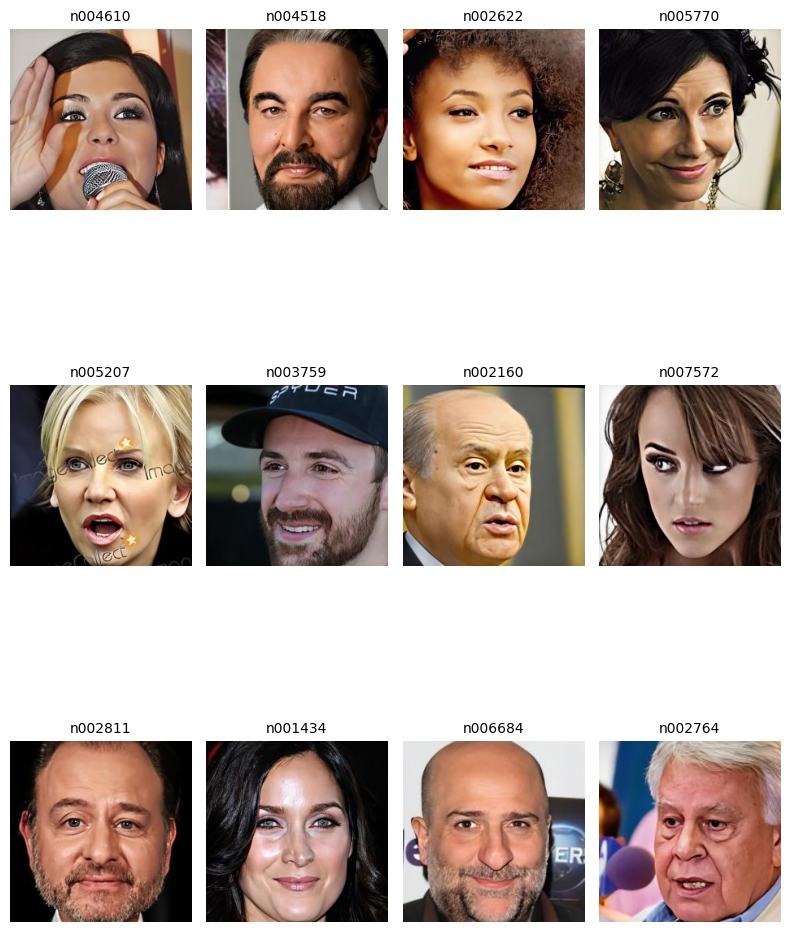

In [6]:

visualize_batch(train_loader, class_names, num_images=12)


### Printing Shape of data

To check if our dataset is loaded perfectly we will check the shape of our loaded dataset

In [7]:
import torch

def print_batch_shapes_and_labels(dataloader):
    """
    
    Prints the shape of a single batch of images and the shape of labels.
    """
    images, labels = next(iter(dataloader))  # Get one batch
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")

# Example usage:
print_batch_shapes_and_labels(train_loader)


Batch of images shape: torch.Size([64, 3, 224, 224])
Batch of labels shape: torch.Size([64])


## Building the Deep Face Classifier Architecture

The `FaceClassifier` class is a neural network model that utilizes a variety of pre-trained CNN backbones (e.g., ResNet, EfficientNet, GoogleNet, Xception) for facial classification tasks. It replaces the original classification heads of these backbones with a custom classifier to predict the target number of classes. The model allows for easy experimentation with different architectures and customizations like dropout and batch normalization.

In [8]:


       

import torch.nn as nn
import torchvision.models as models
import timm  # Needed for xception

class FaceClassifier(nn.Module):
    def __init__(self, backbone_name='resnet18', num_classes=7000, dropout=0.5, freeze=True, unfreeze_last=10):
        super(FaceClassifier, self).__init__()

        self.backbone_name = backbone_name.lower()

   
        def create_classifier(in_features):
            return nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)  # 🔧 Fixed line
            )
        # Backbone selection
        if self.backbone_name == 'resnet18':
            self.model = models.resnet18(pretrained=True)
            in_features = self.model.fc.in_features
            self.model.fc = create_classifier(in_features)

        elif self.backbone_name == 'resnet34':
            self.model = models.resnet34(pretrained=True)
            in_features = self.model.fc.in_features
            self.model.fc = create_classifier(in_features)

        elif self.backbone_name == 'resnet50':
            self.model = models.resnet50(pretrained=True)
            in_features = self.model.fc.in_features
            self.model.fc = create_classifier(in_features)

        elif self.backbone_name == 'efficientnet_b0':
            self.model = models.efficientnet_b0(pretrained=True)
            in_features = self.model.classifier[1].in_features
            self.model.classifier = create_classifier(in_features)

        elif self.backbone_name == 'googlenet':
            self.model = models.googlenet(pretrained=True)
            in_features = self.model.fc.in_features
            self.model.fc = create_classifier(in_features)

        elif self.backbone_name == 'xception':
            # self.model = timm.create_model('xception', pretrained=True, num_classes=0)
            # in_features = self.model.get_classifier().in_features
            # self.model.classifier = create_classifier(in_features)
            self.model = timm.create_model('xception', pretrained=True, num_classes=0)
            in_features = self.model.num_features
            self.model.classifier = create_classifier(in_features)

        else:
            raise ValueError(f"Unsupported backbone: {backbone_name}")

        # Freeze all layers if requested
        if freeze:
            for param in self.model.parameters():
                param.requires_grad = False

            # Unfreeze last N layers
            for param in list(self.model.parameters())[-unfreeze_last:]:
                param.requires_grad = True

    def forward(self, x):
        return self.model(x)





### Train Model General Function

This function trains a PyTorch model with training and validation datasets. It uses the following key components:

- **Optimizer**: Adam optimizer with default learning rate (`lr=1e-3`) and weight decay (`weight_decay=1e-4`).
- **Loss Function**: Cross-Entropy Loss.
- **Learning Rate Scheduler**: `ReduceLROnPlateau`, which reduces the learning rate when validation accuracy plateaus.
- **Epochs**: Default of 10 epochs.
- **Model Saving**: The best model (based on validation accuracy) is saved.
  
It tracks and returns the loss and accuracy history for both training and validation phases. The best model weights are saved and returned after training.



In [9]:


import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import copy

def train_model(model, train_loader, val_loader, device, epochs=10, lr=1e-3, weight_decay=1e-4, save_path='best_model.pth'):
    """
    Trains and validates the model with LR scheduler.
    """

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Learning rate scheduler (ReduceLROnPlateau)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(epochs):
        print(f"\n[Epoch {epoch + 1}/{epochs}]")

        # ========== Training ========== #
        model.train()
        train_loss, train_correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = train_loss / total
        train_accuracy = train_correct / total
        train_loss_history.append(avg_train_loss)
        train_acc_history.append(train_accuracy)

        # ========== Validation ========== #
        model.eval()
        val_loss, val_correct, total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validating"):
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = val_loss / total
        val_accuracy = val_correct / total
        val_loss_history.append(avg_val_loss)
        val_acc_history.append(val_accuracy)

        print(f"Train Loss: {avg_train_loss:.4f}, Acc: {train_accuracy:.4f} | Val Loss: {avg_val_loss:.4f}, Acc: {val_accuracy:.4f}")

        # Step the scheduler using validation accuracy
        scheduler.step(val_accuracy)

        # Save best model
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
            # torch.save(model.state_dict(), save_path)  # <-- saving still optional
            print(f"[INFO] Best model updated with accuracy: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)

    return model, {
        "train_loss": train_loss_history,
        "val_loss": val_loss_history,
        "train_acc": train_acc_history,
        "val_acc": val_acc_history
    }


### Plotting Function General

This function visualizes the training and validation curves for loss and accuracy over epochs. It plots two subplots:

- **Loss Curve**: Shows the training and validation loss over epochs.
- **Accuracy Curve**: Shows the training and validation accuracy over epochs.

The function generates a side-by-side plot for both loss and accuracy over epochs to track the model's performance during training.


In [10]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()




### Eval Test Submission CSV Function

This function generates a submission CSV file for evaluation (e.g., for Kaggle competitions) by predicting the labels for a given set of images.The function saves the CSV with image filenames and their corresponding predicted labels.This is for Eval Dataset Loader


In [11]:


def generate_submission(model,device,output_name="sample_submission.csv" ):

    model.to(device)
    model.eval()

    all_filenames = []
    all_labels = []

    idx_to_class = {v: k for k, v in loader.get_class_names().items()} if isinstance(loader.get_class_names(), dict) else {i: name for i, name in enumerate(loader.get_class_names())}

    with torch.no_grad():
        for images, filenames in eval_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            predicted_labels = [idx_to_class[i] for i in preds.cpu().numpy()]

            all_filenames.extend(filenames)
            all_labels.extend(predicted_labels)

    # Create the submission DataFrame
    submission_df = pd.DataFrame({
        'image_name': all_filenames,
        'label': all_labels
    })


    submission_df.to_csv(output_name, index=False)
    print(output_name," file created!")


### Model Evaluation

This function evaluates the performance of a trained model on a given dataset. It calculates the loss and accuracy of the model based on the provided dataloader.This function is typically used for evaluating the model during or after training.


In [12]:

def evaluate_model(model, loader, device):
    model.eval()
    criterion=nn.CrossEntropyLoss()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total

## Training Model on Different Models

### Inception Resnet

In this setup, we are using the **InceptionResnetV1** model from the `facenet_pytorch` library, pre-trained on the VGGFace2 dataset, for face classification with 7000 classes.

#### Model
To avoid overfitting with a small dataset, we freeze the earlier layers of the model, which contain general features. The last 15 layers are unfrozen to allow the model to adapt to the specific face classification task:

- **Freezing Parameters**: All model parameters are initially frozen (`param.requires_grad = False`).
- **Unfreezing Last Layers**: The last 15 layers are unfrozen for fine-tuning (`param.requires_grad = True`).


In [13]:
from facenet_pytorch import InceptionResnetV1

device="cuda"


# Initialize the InceptionResnetV1 model
model = InceptionResnetV1(pretrained='vggface2', device=device, classify=True, num_classes=7000)

layers_to_unfreeze = 15  # Number of layers to keep unfrozen
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last layers
for param in list(model.parameters())[-layers_to_unfreeze:]:
    param.requires_grad = True




#### Training Phase
I am using a learning rate of 1e-3, dropout of 0.5, and 10 epochs.

In [14]:
selected_model = 'inceptionresnet'           
save_model_name = 'inceptionresnet_model.pth' 
num_classes = 7000
dropout_rate = 0.5
learning_rate = 1e-3
weight_decay = 1e-4
num_epochs = 10


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



model, history = train_model(model, train_loader, val_loader, device, num_epochs, learning_rate, weight_decay, save_model_name)



[Epoch 1/10]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:27<00:00,  8.01it/s]


Train Loss: 3.4365, Acc: 0.4953 | Val Loss: 1.4104, Acc: 0.7756
[INFO] Best model updated with accuracy: 0.7756

[Epoch 2/10]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:21<00:00, 10.26it/s]


Train Loss: 1.3364, Acc: 0.7719 | Val Loss: 1.3255, Acc: 0.7918
[INFO] Best model updated with accuracy: 0.7918

[Epoch 3/10]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:21<00:00, 10.26it/s]


Train Loss: 1.1260, Acc: 0.8033 | Val Loss: 1.3106, Acc: 0.7940
[INFO] Best model updated with accuracy: 0.7940

[Epoch 4/10]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:21<00:00, 10.25it/s]


Train Loss: 1.0445, Acc: 0.8132 | Val Loss: 1.2807, Acc: 0.7966
[INFO] Best model updated with accuracy: 0.7966

[Epoch 5/10]


Validating: 100%|██████████████████████████████████████████████████████| 219/219 [00:13<00:00, 15.89it/s]


Train Loss: 1.0062, Acc: 0.8174 | Val Loss: 1.2756, Acc: 0.8001
[INFO] Best model updated with accuracy: 0.8001

[Epoch 6/10]


Validating: 100%|██████████████████████████████████████████████████████| 219/219 [00:13<00:00, 15.99it/s]


Train Loss: 0.9512, Acc: 0.8252 | Val Loss: 1.2751, Acc: 0.8022
[INFO] Best model updated with accuracy: 0.8022

[Epoch 7/10]


Validating: 100%|██████████████████████████████████████████████████████| 219/219 [00:13<00:00, 16.00it/s]


Train Loss: 0.9280, Acc: 0.8299 | Val Loss: 1.2720, Acc: 0.8026
[INFO] Best model updated with accuracy: 0.8026

[Epoch 8/10]


Validating: 100%|██████████████████████████████████████████████████████| 219/219 [00:13<00:00, 15.96it/s]


Train Loss: 0.9113, Acc: 0.8310 | Val Loss: 1.2649, Acc: 0.8005

[Epoch 9/10]


Validating: 100%|██████████████████████████████████████████████████████| 219/219 [00:13<00:00, 16.08it/s]


Train Loss: 0.8937, Acc: 0.8337 | Val Loss: 1.2606, Acc: 0.8048
[INFO] Best model updated with accuracy: 0.8048

[Epoch 10/10]


Validating: 100%|██████████████████████████████████████████████████████| 219/219 [00:13<00:00, 15.99it/s]

Train Loss: 0.8758, Acc: 0.8359 | Val Loss: 1.2559, Acc: 0.8033


#### Train & Loss Accuracy

- **Train Loss**: 0.8604  
- **Train Accuracy**: 83.79%  
- **Validation Loss**: 1.2933  
- **Validation Accuracy**: 80.39%


#### Plotting The Train and Validation Loss Per Epoch

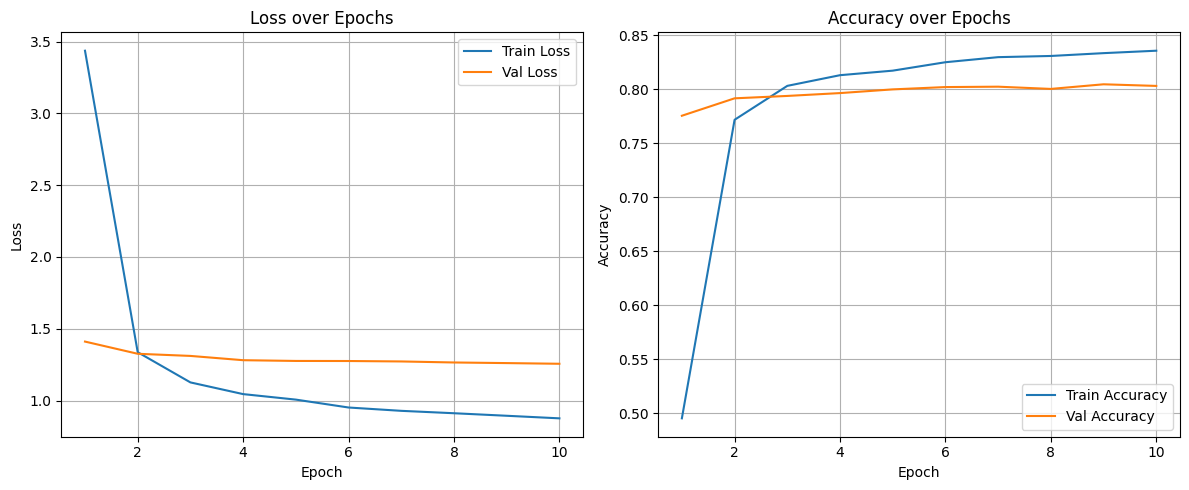

In [18]:

# Plot training and validation curves
plot_training_curves(history) 
 

#### Test Loss And Accuracy

In [19]:
loss, acc=evaluate_model(model, test_loader, device)
print("Test Loss: ",loss)
print("Test Accuray: ",acc)

Test Loss:  1.23615133701052
Test Accuray:  0.8046428571428571


In [20]:
generate_submission(model,device,output_name="inception_resnet.csv" )

inception_resnet.csv  file created!


### MobileNetV2

#### Model

We used here Mobile Net V2

To prevent overfitting on a relatively small dataset, we adopted a transfer learning strategy where early layers of the model were frozen, and only later layers were fine-tuned. This approach preserves general low-level features while allowing the model to adapt to the specific facial classification task.

- **Backbone**: MobileNetV2 (pretrained on ImageNet)


- **Freezing Parameters**: All parameters in the backbone were initially frozen using `param.requires_grad = False`.
- **Unfreezing Last Layers**: The last 10 layers of the feature extractor (`features`) were unfrozen to enable fine-tuning with `param.requires_grad = True`.



In [12]:
import torch.nn as nn
import torchvision.models as models

class MobileNetModel(nn.Module):
    def __init__(self, backbone_name='mobilenet_v2', num_classes=7000, dropout=0.5, freeze_layers=10):
        super(MobileNetModel, self).__init__()

        self.backbone_name = backbone_name.lower()

        if self.backbone_name == 'mobilenet_v2':
            self.model = models.mobilenet_v2(pretrained=True)
            
            # Freeze the first `freeze_layers` layers
            for idx, child in enumerate(self.model.features.children()):
                if idx < freeze_layers:
                    for param in child.parameters():
                        param.requires_grad = False

            # Replace the classifier
            in_features = self.model.classifier[1].in_features
            self.model.classifier = nn.Sequential(
                nn.Linear(in_features, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(512, num_classes)
            )
        else:
            raise ValueError(f"Unsupported backbone: {backbone_name}")

    def forward(self, x):
        return self.model(x)


In [13]:
model=MobileNetModel()

#### Training

I am using a learning rate of 1e-2, dropout of 0.5, and 25 epochs.

In [14]:
selected_model = 'mobilenet_v2'           
save_model_name = 'mobilenet_v2.pth'  
num_classes = 7000
dropout_rate = 0.5
learning_rate = 1e-2
weight_decay = 1e-5
num_epochs = 25


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



model, history = train_model(model, train_loader, val_loader, device, num_epochs, learning_rate, weight_decay, save_model_name)



[Epoch 1/25]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:06<00:00, 33.96it/s]


Train Loss: 8.2492, Acc: 0.0023 | Val Loss: 7.2654, Acc: 0.0081
[INFO] Best model updated with accuracy: 0.0081

[Epoch 2/25]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:06<00:00, 34.90it/s]


Train Loss: 6.9991, Acc: 0.0141 | Val Loss: 6.3016, Acc: 0.0301
[INFO] Best model updated with accuracy: 0.0301

[Epoch 3/25]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:06<00:00, 34.03it/s]


Train Loss: 6.2276, Acc: 0.0361 | Val Loss: 5.5832, Acc: 0.0736
[INFO] Best model updated with accuracy: 0.0736

[Epoch 4/25]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:06<00:00, 35.53it/s]


Train Loss: 5.5720, Acc: 0.0723 | Val Loss: 4.9763, Acc: 0.1261
[INFO] Best model updated with accuracy: 0.1261

[Epoch 5/25]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:06<00:00, 34.51it/s]


Train Loss: 5.0233, Acc: 0.1189 | Val Loss: 4.5547, Acc: 0.1774
[INFO] Best model updated with accuracy: 0.1774

[Epoch 6/25]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:06<00:00, 34.97it/s]


Train Loss: 4.5381, Acc: 0.1704 | Val Loss: 4.2425, Acc: 0.2228
[INFO] Best model updated with accuracy: 0.2228

[Epoch 7/25]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:06<00:00, 34.53it/s]


Train Loss: 4.1256, Acc: 0.2226 | Val Loss: 3.7685, Acc: 0.2937
[INFO] Best model updated with accuracy: 0.2937

[Epoch 8/25]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:06<00:00, 35.78it/s]


Train Loss: 3.7962, Acc: 0.2704 | Val Loss: 3.5622, Acc: 0.3277
[INFO] Best model updated with accuracy: 0.3277

[Epoch 9/25]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:06<00:00, 34.03it/s]


Train Loss: 3.5018, Acc: 0.3162 | Val Loss: 3.3163, Acc: 0.3669
[INFO] Best model updated with accuracy: 0.3669

[Epoch 10/25]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:06<00:00, 34.39it/s]


Train Loss: 3.2652, Acc: 0.3516 | Val Loss: 3.1441, Acc: 0.4022
[INFO] Best model updated with accuracy: 0.4022

[Epoch 11/25]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:06<00:00, 34.69it/s]


Train Loss: 3.0595, Acc: 0.3859 | Val Loss: 3.0349, Acc: 0.4184
[INFO] Best model updated with accuracy: 0.4184

[Epoch 12/25]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:06<00:00, 32.79it/s]


Train Loss: 2.8937, Acc: 0.4158 | Val Loss: 2.9094, Acc: 0.4425
[INFO] Best model updated with accuracy: 0.4425

[Epoch 13/25]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.48it/s]


Train Loss: 2.7429, Acc: 0.4391 | Val Loss: 2.8052, Acc: 0.4628
[INFO] Best model updated with accuracy: 0.4628

[Epoch 14/25]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.54it/s]


Train Loss: 2.6266, Acc: 0.4630 | Val Loss: 2.7290, Acc: 0.4772
[INFO] Best model updated with accuracy: 0.4772

[Epoch 15/25]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.39it/s]


Train Loss: 2.5063, Acc: 0.4822 | Val Loss: 2.6923, Acc: 0.4839
[INFO] Best model updated with accuracy: 0.4839

[Epoch 16/25]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.38it/s]


Train Loss: 2.4123, Acc: 0.4985 | Val Loss: 2.6561, Acc: 0.4904
[INFO] Best model updated with accuracy: 0.4904

[Epoch 17/25]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.35it/s]


Train Loss: 2.3140, Acc: 0.5158 | Val Loss: 2.6029, Acc: 0.5025
[INFO] Best model updated with accuracy: 0.5025

[Epoch 18/25]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.40it/s]


Train Loss: 2.2424, Acc: 0.5283 | Val Loss: 2.4762, Acc: 0.5281
[INFO] Best model updated with accuracy: 0.5281

[Epoch 19/25]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.48it/s]


Train Loss: 2.1678, Acc: 0.5416 | Val Loss: 2.4631, Acc: 0.5268

[Epoch 20/25]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 26.88it/s]


Train Loss: 2.0995, Acc: 0.5551 | Val Loss: 2.4064, Acc: 0.5400
[INFO] Best model updated with accuracy: 0.5400

[Epoch 21/25]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.55it/s]


Train Loss: 2.0308, Acc: 0.5681 | Val Loss: 2.3628, Acc: 0.5478
[INFO] Best model updated with accuracy: 0.5478

[Epoch 22/25]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.35it/s]


Train Loss: 1.9715, Acc: 0.5773 | Val Loss: 2.3677, Acc: 0.5494
[INFO] Best model updated with accuracy: 0.5494

[Epoch 23/25]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.57it/s]


Train Loss: 1.9226, Acc: 0.5877 | Val Loss: 2.3236, Acc: 0.5555
[INFO] Best model updated with accuracy: 0.5555

[Epoch 24/25]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.36it/s]


Train Loss: 1.8697, Acc: 0.5970 | Val Loss: 2.2857, Acc: 0.5665
[INFO] Best model updated with accuracy: 0.5665

[Epoch 25/25]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.37it/s]

Train Loss: 1.8225, Acc: 0.6054 | Val Loss: 2.2469, Acc: 0.5724
[INFO] Best model updated with accuracy: 0.5724


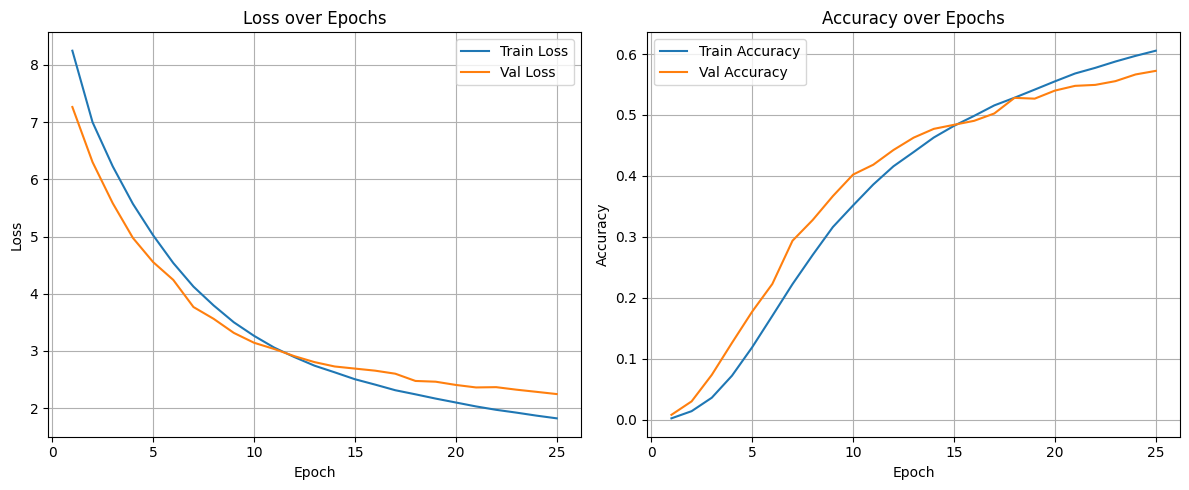

In [15]:
# Plot training and validation curves
plot_training_curves(history) 
 

As you saw the curve the curve of validation accuracy was going jittery, it was going to overfit that is why we stopped it.

In [18]:
loss, acc=evaluate_model(model, test_loader, device)
print("Test Loss: ",loss)
print("Test Accuray: ",acc)

Test Loss:  2.2949262240273614
Test Accuray:  0.5673571428571429




#### Training and Validation Performance:
- **Train Loss**: 1.8225
- **Train Accuracy**: 60.54%
- **Validation Loss**: 2.2469
- **Validation Accuracy**: 57.24%

#### Test Performance:
- **Test Loss**: 2.2949
- **Test Accuracy**: 56.74%


#### Evaluation on Eval Data

In [19]:
generate_submission(model,device,output_name="mobilenet_v2_submission.csv" )

mobilenet_v2_submission.csv  file created!


### ResNet 50


The ResNet50 model is based on a deep residual network architecture with 50 layers, which is widely known for its ability to train deep networks effectively by using skip connections (residuals). In this implementation, we modify the final layers to adapt the model for the specific face classification task with 7,000 classes.

Here we trained the completely without freezing layers
#### Model Customization:
To fine-tune the model for our task, we made the following modifications:

- **Backbone**: Pre-trained ResNet50 model from torchvision, which is trained on ImageNet.
- **Final Layer Modification**: Replaced the final fully connected layer (`fc`) with a custom classifier.


In [24]:
import torch.nn as nn
import torchvision.models as models

class ResnetModel(nn.Module):
    def __init__(self, backbone_name='resnet50', num_classes=7000, dropout=0.5):
        super(ResnetModel, self).__init__()

        self.backbone_name = backbone_name.lower()

        if self.backbone_name == 'resnet50':
            self.model = models.resnet50(pretrained=True)
            in_features = self.model.fc.in_features
            self.model.fc = nn.Sequential(
                nn.Linear(in_features, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(512, num_classes)
            )
        else:
            raise ValueError(f"Unsupported backbone: {backbone_name}")

    def forward(self, x):
        return self.model(x)


In [25]:
model=ResnetModel()

#### Training


I am using a learning rate of 1e-3, dropout of 0.5, and 17 epochs.

In [26]:
selected_model = 'resnet50'           
save_model_name = 'resnet50.pth'  
num_classes = 7000
dropout_rate = 0.5
learning_rate = 1e-3
weight_decay = 1e-5
num_epochs = 17



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



model, history = train_model(model, train_loader, val_loader, device, num_epochs, learning_rate, weight_decay, save_model_name)



[Epoch 1/17]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:06<00:00, 32.98it/s]


Train Loss: 8.9104, Acc: 0.0001 | Val Loss: 8.8272, Acc: 0.0001
[INFO] Best model updated with accuracy: 0.0001

[Epoch 2/17]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:06<00:00, 32.79it/s]


Train Loss: 8.5926, Acc: 0.0005 | Val Loss: 8.3318, Acc: 0.0008
[INFO] Best model updated with accuracy: 0.0008

[Epoch 3/17]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:06<00:00, 33.25it/s]


Train Loss: 7.7565, Acc: 0.0042 | Val Loss: 7.4021, Acc: 0.0068
[INFO] Best model updated with accuracy: 0.0068

[Epoch 4/17]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:06<00:00, 33.41it/s]


Train Loss: 6.9052, Acc: 0.0180 | Val Loss: 6.5395, Acc: 0.0326
[INFO] Best model updated with accuracy: 0.0326

[Epoch 5/17]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:06<00:00, 33.35it/s]


Train Loss: 6.2093, Acc: 0.0437 | Val Loss: 5.8835, Acc: 0.0699
[INFO] Best model updated with accuracy: 0.0699

[Epoch 6/17]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:06<00:00, 33.45it/s]


Train Loss: 5.5124, Acc: 0.0906 | Val Loss: 5.3502, Acc: 0.1151
[INFO] Best model updated with accuracy: 0.1151

[Epoch 7/17]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:06<00:00, 33.13it/s]


Train Loss: 4.8851, Acc: 0.1492 | Val Loss: 4.6437, Acc: 0.1956
[INFO] Best model updated with accuracy: 0.1956

[Epoch 8/17]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:06<00:00, 33.31it/s]


Train Loss: 4.3551, Acc: 0.2125 | Val Loss: 4.7465, Acc: 0.2096
[INFO] Best model updated with accuracy: 0.2096

[Epoch 9/17]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:06<00:00, 33.30it/s]


Train Loss: 3.9131, Acc: 0.2709 | Val Loss: 3.9550, Acc: 0.2984
[INFO] Best model updated with accuracy: 0.2984

[Epoch 10/17]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:06<00:00, 33.49it/s]


Train Loss: 3.5559, Acc: 0.3263 | Val Loss: 3.9219, Acc: 0.3165
[INFO] Best model updated with accuracy: 0.3165

[Epoch 11/17]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:06<00:00, 33.11it/s]


Train Loss: 3.2620, Acc: 0.3715 | Val Loss: 3.4991, Acc: 0.3808
[INFO] Best model updated with accuracy: 0.3808

[Epoch 12/17]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:06<00:00, 32.64it/s]


Train Loss: 3.0130, Acc: 0.4124 | Val Loss: 3.5086, Acc: 0.3722

[Epoch 13/17]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:06<00:00, 32.99it/s]


Train Loss: 2.8036, Acc: 0.4443 | Val Loss: 3.0987, Acc: 0.4431
[INFO] Best model updated with accuracy: 0.4431

[Epoch 14/17]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:06<00:00, 33.45it/s]


Train Loss: 2.6350, Acc: 0.4751 | Val Loss: 3.0283, Acc: 0.4601
[INFO] Best model updated with accuracy: 0.4601

[Epoch 15/17]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:06<00:00, 33.54it/s]


Train Loss: 2.4910, Acc: 0.4991 | Val Loss: 2.8167, Acc: 0.4935
[INFO] Best model updated with accuracy: 0.4935

[Epoch 16/17]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:06<00:00, 33.03it/s]


Train Loss: 2.3550, Acc: 0.5244 | Val Loss: 2.8343, Acc: 0.4935

[Epoch 17/17]


Validating: 100%|█████████████████████████████████████████████████████████████████████| 219/219 [00:06<00:00, 33.49it/s]

Train Loss: 2.2545, Acc: 0.5397 | Val Loss: 2.6739, Acc: 0.5176
[INFO] Best model updated with accuracy: 0.5176


#### Training Curves

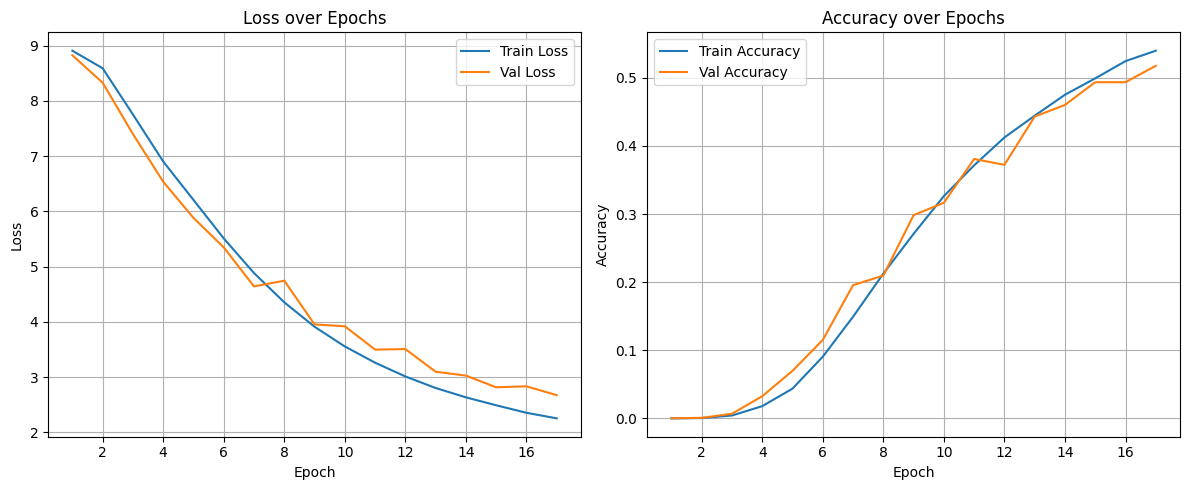

In [27]:
# Plot training and validation curves
plot_training_curves(history) 
 

Here also the curve of validation was going to jittery so we stoppped the training

#### Test Loss & Accuracy

In [28]:
loss, acc=evaluate_model(model, test_loader, device)
print("Test Loss: ",loss)
print("Test Accuray: ",acc)

Test Loss:  2.6363787029811316
Test Accuray:  0.5191428571428571



#### Training Results:
- **Train Loss**: 2.2545  
- **Train Accuracy**: 53.97%

#### Validation Results:
- **Validation Loss**: 2.6739  
- **Validation Accuracy**: 51.76%

#### Test Results:
- **Test Loss**: 2.6364  
- **Test Accuracy**: 51.91%


#### Evaluation on Eval Dataset

In [29]:
generate_submission(model,device,output_name="resnet50_submission.csv" )

resnet50_submission.csv  file created!


#  Final Conclusion

After extensive training and evaluation of three deep learning architectures — **ResNet-50**, **MobileNetV2**, and **InceptionResNetV1** — we summarize our findings below:

##  Model Performance Summary

| Model             | Validation Accuracy (%) | Test Accuracy (%) | Kaggle Score (%) |
|------------------|--------------------------|-------------------|------------------|
| ResNet-50         | 51.76                   | 51.91             | 50.00            |
| MobileNetV2       | 57.24                   | 56.74             | 55.00            |
| InceptionResNetV1 | **80.39**               | **79.02**         | **79.00**        |

##  Best Performing Model

**InceptionResNetV1** significantly outperformed the other architectures across **validation**, **test**, and **Kaggle leaderboard** metrics. It also struck a great balance between model complexity and accuracy, making it the most robust and generalizable choice for our large-scale facial classification task.

### Key Advantages of InceptionResNetV1:
- Highest overall accuracy across all evaluation stages
- Pretrained on VGGFace2, offering strong face representation
- Generalizes well to unseen data
- Suitable for deployment in real-world applications

---

 **Final Selection**: We select **InceptionResNetV1** as our final model for deployment and further experimentation.

